In [1]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

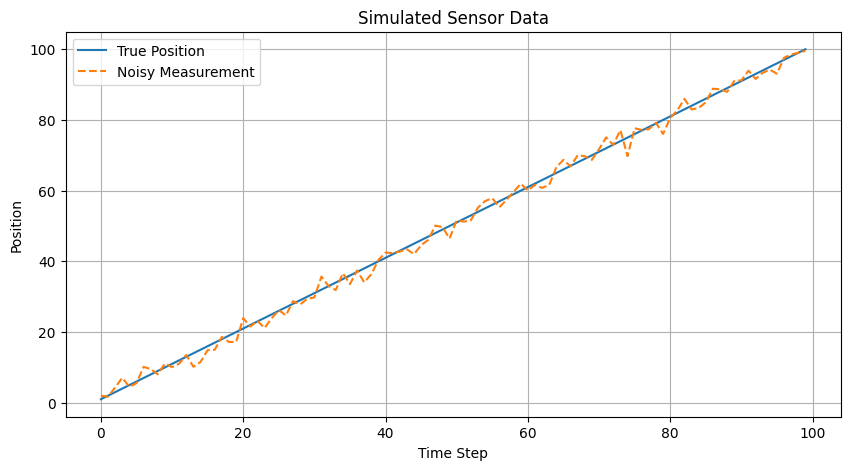

In [2]:
np.random.seed(42)

# True position over time (e.g., moving object)
n_steps = 100
true_position = np.cumsum(np.ones(n_steps))  # constant velocity = 1

# Simulate noisy sensor readings
noise_std = 2.0
noisy_measurements = true_position + np.random.normal(0, noise_std, size=n_steps)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(true_position, label='True Position')
plt.plot(noisy_measurements, label='Noisy Measurement', linestyle='dashed')
plt.legend()
plt.title("Simulated Sensor Data")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.grid(True)
plt.show()


In [4]:
# Initialize Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=1)

dt = 1.0  # time step

# State transition matrix (position + velocity)
kf.F = np.array([[1, dt],
                 [0, 1]])

# Measurement function (we only measure position)
kf.H = np.array([[1, 0]])

# Initial state estimate: position=0, velocity=1
kf.x = np.array([[0],
                 [1]])

# Initial uncertainty covariance
kf.P *= 1000.

# Measurement noise
kf.R = noise_std**2  # same as measurement variance

# Process noise (model uncertainty)
kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.01)

# Identity matrix for later use
I = np.eye(2)

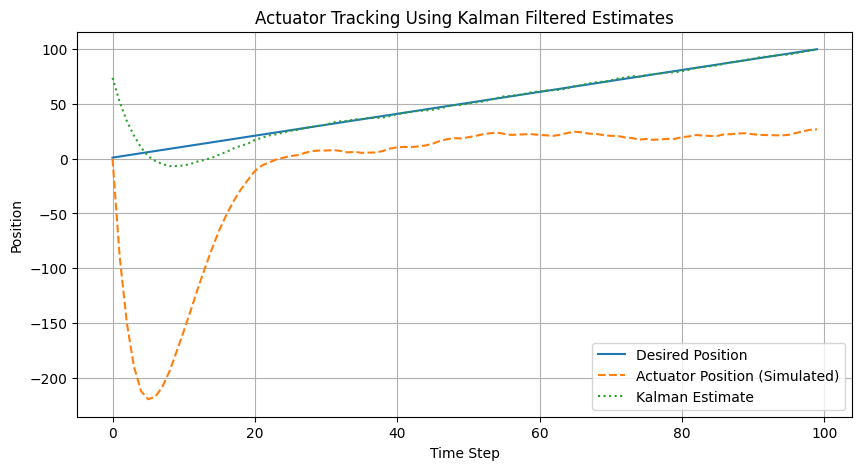

In [28]:
filtered_positions = []

for z in noisy_measurements:
    kf.predict()
    kf.update(z)
    filtered_positions.append(kf.x[0, 0])

# Desired trajectory (e.g., follow a straight line)
desired_position = true_position.copy()

# Initialize actuator output and system response
actuator_positions = [0]  # starts at position 0
Kp = 1.2
Ki = 0.01
Kd = 0.01
integral_error = 0
prev_error = 0

for t in range(1, n_steps):
    est_pos = filtered_positions[t-1]
    error = desired_position[t-1] - est_pos
    integral_error += error
    derivative = error - prev_error
    control_signal = Kp * error + Ki * integral_error + Kd * derivative
    new_pos = actuator_positions[-1] + control_signal + np.random.normal(0, 0.5)
    actuator_positions.append(new_pos)
    prev_error = error

# Plot actuator performance
plt.figure(figsize=(10, 5))
plt.plot(desired_position, label='Desired Position')
plt.plot(actuator_positions, label='Actuator Position (Simulated)', linestyle='dashed')
plt.plot(filtered_positions, label='Kalman Estimate', linestyle='dotted')
plt.legend()
plt.title("Actuator Tracking Using Kalman Filtered Estimates")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.grid(True)
plt.show()

In [6]:
tracking_error = np.abs(np.array(actuator_positions) - np.array(desired_position))
mean_error = np.mean(tracking_error)
print(f"Mean Absolute Tracking Error: {mean_error:.2f}")
plt.savefig("kalman_actuator_tracking.png", dpi=300)


Mean Absolute Tracking Error: 39.88


<Figure size 640x480 with 0 Axes>